In [ ]:
import numpy as np
from multiprocessing import Pool

from functools import partial
import pickle as pkl
import gzip
import os

import games
import subprocess


def evaluate_parallel(nbCores, n_folds, horizon, alg, game, type, label):
    print("nbCores:", nbCores, "nbFolds:", n_folds, "Horizon:", horizon)
    pool = Pool(processes = nbCores) 
    task = Evaluation(horizon, )

    np.random.seed(1)
    distributions = []
    tasks = []
    nfold_list =[]
    labels = []

    for jobid in range(n_folds):
        
        if type == 'imbalanced' :
            p = np.random.uniform(0, 0.2) if np.random.random() < 0.5 else np.random.uniform(0.8, 1)
        elif type == 'balanced':
            p = np.random.uniform(0.4,0.6)
        else:
            p = np.random.uniform(0,1)

        distributions.append( [p, 1-p] )
        tasks.append( type )
        nfold_list.append(n_folds)
        labels.append( label )

    return np.asarray(  pool.map( partial( task.eval_policy_once, alg, game ), zip(distributions ,tasks, nfold_list, labels, range(n_folds)) ) ) 



class Evaluation:

    def __init__(self, horizon, ):
        self.horizon = horizon

    def get_outcomes(self, game):
        outcomes = np.random.choice( game.n_outcomes , p= list( game.outcome_dist.values() ), size= self.horizon) 
        return outcomes

    def get_feedback(self, game, action, outcome):
        return game.FeedbackMatrix[ action ][ outcome ]

    def eval_policy_once(self, alg, game, job):

        alg.reset()

        distribution, task, nfold, label, jobid = job

        np.random.seed(jobid)

        outcome_distribution =  {'spam':distribution[0],'ham':distribution[1]}

        game.set_outcome_distribution( outcome_distribution, jobid )
        outcomes = self.get_outcomes(game)

        action_counter = np.zeros( (game.n_actions, self.horizon) )        

        for t in range(self.horizon):

            # policy chooses one action
            action = alg.get_action(t, None)

            # Environment chooses one outcome
            outcome = outcomes[t]

            # print('t', t, 'action', action, 'outcome', outcome, )
            feedback =  self.get_feedback( game, action, outcome )

            alg.update(action, feedback, outcome, None, t)

            for i in range(game.n_actions):
                if i == action:
                    action_counter[i][t] = action_counter[i][t-1] +1
                else:
                    action_counter[i][t] = action_counter[i][t-1]

        regret = np.array( [ game.delta(i) for i in range(game.n_actions) ] ).T @ action_counter

        with gzip.open( './results/{}/icml_{}_{}_{}_{}_{}.pkl.gz'.format(game.name, task,  self.horizon, nfold, label, jobid) ,'wb') as f:
                pkl.dump(regret,f)

        print('finished {}'.format(jobid))

        return regret


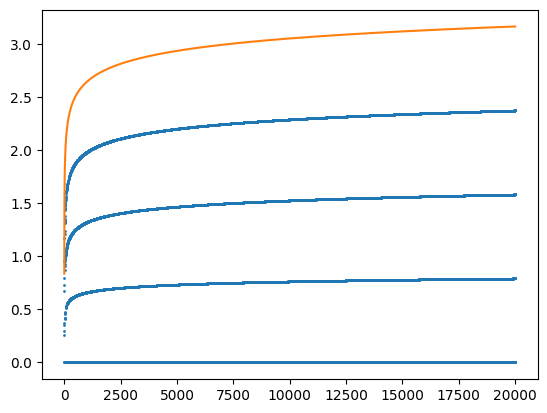

In [31]:
import matplotlib.pyplot as plt

def divide_interval(start, end, k):
    intervals = np.linspace(start, end, k ).tolist()
    return intervals

def obtain_probability(t):
    alpha = 1.01
    K = 5
    sigma = 10
    epsilon = 10e-7
    U = np.sqrt( alpha  * np.log(t) ) 
    rhos = divide_interval(0, U, K)
    p_m_hat =  np.array([ np.exp( -(rhos[i]**2) / (2*sigma**2)  )  for i in range(len(rhos)-1) ] )
    p_m = (1 - epsilon) * p_m_hat / p_m_hat.sum()
    p_m = p_m.tolist()
    p_m.append(epsilon)
        
    Z = np.random.choice(rhos, p= p_m)
    return Z

rand = []
det = []
for t in range(2,20000):
    z = obtain_probability(t)
    rand.append(z)
    det.append( np.sqrt( 1.01 * np.log(t) ) )

plt.plot( range(2,20000) , rand, '.', markersize = 2  )
plt.plot( range(2,20000) , det  )

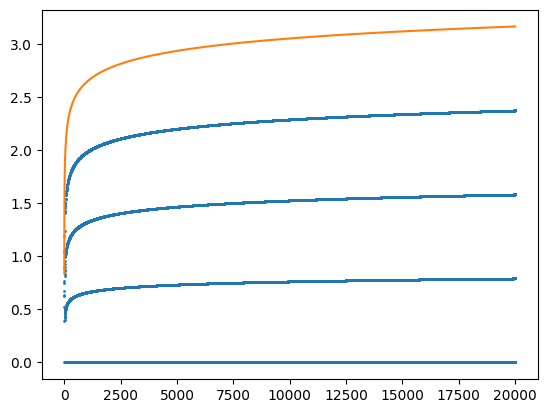

In [30]:
import matplotlib.pyplot as plt

def divide_interval(start, end, k):
    intervals = np.linspace(start, end, k ).tolist()
    return intervals

def obtain_probability(t):
    alpha = 1.01
    K = 5
    sigma = 1/8
    epsilon = 10e-7
    U = np.sqrt( alpha  * np.log(t) ) 
    rhos = divide_interval(0, U, K)
    p_m_hat =  np.array([ np.exp( -(rhos[i]**2) / 2*(sigma**2)  )  for i in range(len(rhos)-1) ] )
    p_m = (1 - epsilon) * p_m_hat / p_m_hat.sum()
    p_m = p_m.tolist()
    p_m.append(epsilon)
        
    Z = np.random.choice(rhos, p= p_m)
    return Z

rand = []
det = []
for t in range(2,20000):
    z = obtain_probability(t)
    rand.append(z)
    det.append( np.sqrt( 1.01 * np.log(t) ) )

plt.plot( range(2,20000) , rand, '.', markersize = 2  )
plt.plot( range(2,20000) , det  )

In [ ]:
import randcbp

horizon = 5000
game = games.apple_tasting(False)
# alg = TSPM.TSPM_alg(game, horizon, 1) #, TSPM.TSPM_alg(game, horizon, 0),
# alg = cbp.CBP(  game, 1.01) 
alg = randcbp.RandCBP(  game, 1.01, 1/8, 10, 10e-7) 
label = 'CBP' #, 'TSPM_0'   
task = Evaluation(horizon, )
p = 0.9
job = [p, 1-p],'imbalanced',96,'CBP', 6
result = task.eval_policy_once(alg, game, job)
import matplotlib.pyplot as plt
plt.plot(range(len(result)),result)

In [ ]:
def loadall_results(path, horizon, n_folds):
    result = np.zeros( (n_folds, horizon) )
    with gzip.open(  path ,'rb') as f:
        for i in range(n_folds):
            try:
                res = pkl.load(f)
                result[i] = res
            except EOFError:
                break
    return result

game = 'AT'
direct = './results/{}/'.format(game)
path = os.path.join(direct, 'other_imbalanced_20000_96_RandCBP.pkl.gz'.format(task) )
result = loadall_results(path, horizon, n_folds)

In [ ]:


# algos = [  randcbp.RandCBP(  game, 1.01, 1/32, 5, 10e-7),  ]
# labels = [ 'RandCBP',  ] 

# algos = [  PM_DMED.PM_DMED(  game, horizon, 1) ]
# labels = [ 'PM_DMED'  ] 

# algos = [ bpm.BPM(game,horizon) ]
# labels = [ 'BPM_LEAST' ] 

# algos = [ random_algo.Random(game,horizon) ]
# labels = [ 'random' ] 

# algos = [ cbp.CBP(  game, 1.01), PM_DMED.PM_DMED(  game, horizon, 1),  ]
# labels = [ 'CBP', 'PM_DMED',  ] 

In [33]:


n_cores = 8
n_folds = 96
horizon = 20000

import TSPM
import PM_DMED
import bpm
import cbp
# import randcbp
import random_algo





game = games.apple_tasting(False)
algos = [ cbp.CBP(  game, 1.01), 
          PM_DMED.PM_DMED(  game, horizon, 1),
          TSPM.TSPM_alg(game, horizon, 1),
          TSPM.TSPM_alg(game, horizon, 0),
          bpm.BPM(game,horizon) ]
labels = [ 'CBP', 'PM_DMED_1', 'TSPM_1', 'TSPM_0', 'BPM_LEAST',  ]  


# game = games.label_efficient()
# algos = [ cbp.CBP(  game, 1.01), PM_DMED.PM_DMED(  game, horizon, 1) ] 
# labels = [  'CBP', 'PM_DMED_1' ] 


# algos = [ cbp.CBP(  game, 1.01),]
# labels = [ 'CBP',  ]  

# algos = [ random_algo.Random(game,horizon) ]
# labels = [ 'random' ] 

# randcbp.RandCBP(  game, 1.01, 1, 10, 10e-7), 'RandCBP',

#game = games.label_efficient()



for game in [ games.apple_tasting(False) ]: #games.label_efficient()

    for task in ['balanced', 'imbalanced']:
        
        for alg, label in zip( algos,  labels):

            result = evaluate_parallel(n_cores, n_folds, horizon, alg, game, task, label)

            with gzip.open( './results/{}/icml_{}_{}_{}_{}.pkl.gz'.format(game.name, task , horizon, n_folds,  label) ,'wb') as g:

                for jobid in range(n_folds):

                    with gzip.open(  './results/{}/icml_{}_{}_{}_{}_{}.pkl.gz'.format(game.name, task, horizon, n_folds,  label, jobid) ,'rb') as f:
                        r = pkl.load(f)

                    pkl.dump(r, g)
                            
                    bashCommand = 'rm ./results/{}/icml_{}_{}_{}_{}_{}.pkl.gz'.format(game.name, task, horizon, n_folds,  label, jobid)
                    process = subprocess.Popen(bashCommand.split(), stdout=subprocess.PIPE)
                    output, error = process.communicate()


n-actions 2 n-outcomes 2 alphabet 3
n-actions 2 n-outcomes 2
n-actions 2 n-outcomes 2
n-actions 2 n-outcomes 2
nbCores: 8 nbFolds: 96 Horizon: 20000


finished 21finished 12

finished 0
finished 9
finished 3
finished 18
finished 15
finished 6
finished 1
finished 13
finished 22
finished 4
finished 7
finished 10
finished 19
finished 16
finished 2
finished 23
finished 8
finished 20
finished 14
finished 5
finished 11
finished 17
finished 24
finished 27
finished 33
finished 30
finished 36
finished 42
finished 39
finished 45
finished 25
finished 31
finished 28
finished 34
finished 37
finished 43
finished 40
finished 46
finished 26
finished 35
finished 29
finished 32
finished 38
finished 44
finished 41
finished 47
finished 48
finished 51
finished 54
finished 57
finished 60
finished 63
finished 69
finished 66
finished 49
finished 55
finished 52
finished 58
finished 67finished 64

finished 61
finished 50
finished 70
finished 59
finished 56
finished 65
finished 53
finished 62
finished 71
finished 68
finished 72
finished 87
finished 81
finished 75
finished 78
finished 90
finished 84
finished 73
finished 93
finished 88
finished 76finished 82

fi